In [32]:
import re
import string
from time import perf_counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import torch
from keras import Sequential
from keras import utils
from keras.src.layers import Conv1D, GlobalMaxPooling1D
from keras.src.layers import Embedding, Dense, Flatten
from keras.src.legacy.preprocessing.text import Tokenizer
from keras.src.utils import pad_sequences
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from numpy import asarray
from numpy import zeros
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, \
    confusion_matrix
from sklearn.metrics import roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import pipeline
from wordcloud import WordCloud

In [33]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liqing/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/liqing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [34]:
data = pd.read_csv('Sentiment140.tenPercent.sample.tweets.tsv', sep='\t')

In [35]:
data.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [36]:
data.shape

(160000, 2)

<Axes: ylabel='count'>

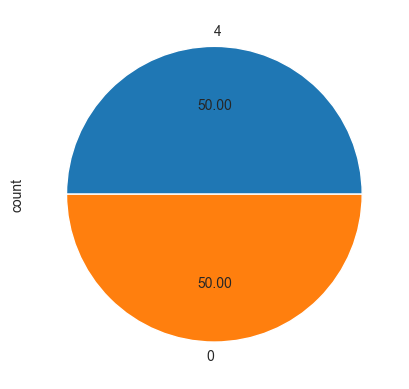

In [37]:
data['sentiment_label'].value_counts().plot.pie(autopct='%.2f')

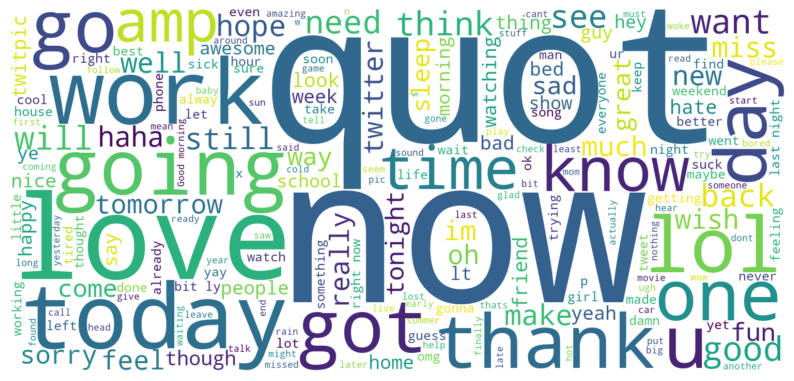

In [38]:
text = " ".join(data['tweet_text'])

# Create a WordCloud object
wordcloud = WordCloud(width=1500, height=700, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Data Preprocessing

In [63]:
def emoji_translator(t):
    emojis = {
        ':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
        ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
        ':-@': 'shocked', ':@': 'shocked', ':-$': 'confused', ':\\': 'annoyed',
        ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
        '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
        '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
        ';-)': 'wink', 'O:-)': 'angel', 'O*-)': 'angel', '(:-D': 'gossip', '=^.^=': 'cat'
    }

    # Create a regex pattern to match any of the emojis
    pattern = re.compile(r'|'.join(re.escape(key) for key in emojis.keys()))

    # Function to replace matched emoji with the corresponding word
    def replace_emoji(match):
        return emojis[match.group(0)]

    # Replace emojis in the text using the pattern
    return pattern.sub(replace_emoji, t)

In [64]:
def basic_text_cleaner(text):
    ''' Make text lowercase, remove punctuations and usertags'''

    # Defining regex patterns.
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1 "
    usertagPattern = r"@\w+"

    text = text.lower()
    text = re.sub(usertagPattern, '', text)
    text = re.sub(urlPattern, '', text, flags=re.MULTILINE)
    text = emoji_translator(text)
    text = re.sub(sequencePattern, seqReplacePattern, text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r' +', ' ', text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if w not in stop_words]
    text = " ".join(filtered_text)

    return text

In [65]:
data['cleaned_text'] = data['tweet_text'].apply(basic_text_cleaner)

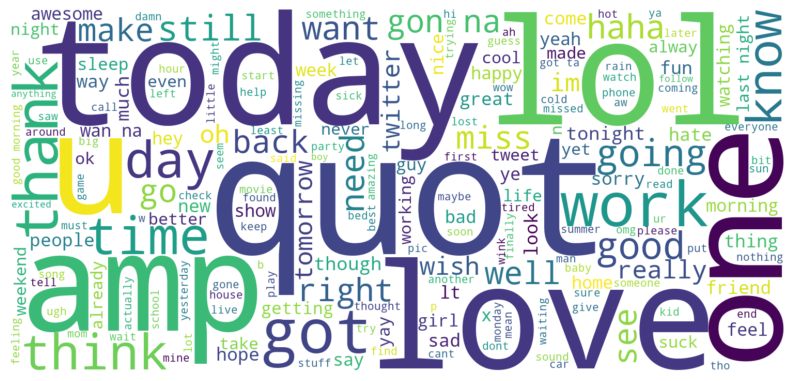

In [66]:
text = " ".join(data['cleaned_text'])

# Create a WordCloud object
wordcloud = WordCloud(width=1500, height=700, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [67]:
data.head()

,sentiment_label,tweet_text,cleaned_text
0,4,"@elephantbird Hey dear, Happy Friday to You A...",hey dear happy friday already rice bowl lunch
1,4,Ughhh layin downnnn Waiting for zeina to co...,ugh layin waiting zeina cook breakfast
2,0,"@greeniebach I reckon he'll play, even if he's...",reckon play even know nothing wink without
3,0,@vaLewee I know! Saw it on the news!,know saw news
4,0,very sad that http://www.fabchannel.com/ has c...,sad closed one web services used years


### Machine Learning Models
In this section,
•	Random Forest classifier
•	Linear support Vector Machine
•	Multinomial Naïve Bayes
•	Logistic Regression

will be trained on the dataset and compared based on their Accuracy, F1_score, precision.



In [68]:
data.shape

(160000, 3)

In [69]:
vectorizer = TfidfVectorizer(max_features=1000)
vectors = vectorizer.fit_transform(data.cleaned_text)
vectorized_data = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())
vectorized_data.head()

,able,absolutely,account,actually,add,afternoon,ago,agree,ah,ahead,...,yes,yesterday,yet,yo,young,youtube,yr,yum,yummy,yup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
X = vectorized_data.copy()
y = data.copy().sentiment_label.apply(lambda x: 1 if x == 4 else x)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [72]:
def evaluate_models(clf, X_train, y_train, X_test, y_test):
    result = {}

    start = perf_counter()
    train_pred = clf.predict(X_train)
    end = perf_counter()
    result['train_pred_time'] = end - start

    start = perf_counter()
    test_pred = clf.predict(X_test)
    end = perf_counter()
    result['test_pred_time'] = end - start

    result['train_accuracy'] = accuracy_score(y_true=y_train, y_pred=train_pred)
    result['train_f1'] = f1_score(y_true=y_train, y_pred=train_pred)
    result['train_precision'] = precision_score(y_true=y_train, y_pred=train_pred)
    result['train_recall'] = precision_score(y_true=y_train, y_pred=train_pred)

    result['test_accuracy'] = accuracy_score(y_true=y_test, y_pred=test_pred)
    result['test_f1'] = f1_score(y_true=y_test, y_pred=test_pred)
    result['test_precision'] = precision_score(y_true=y_test, y_pred=test_pred)
    result['test_recall'] = recall_score(y_true=y_test, y_pred=test_pred)

    return result




In [73]:
# cv = KFold(n_splits=3, random_state=42,shuffle=True)
clf_RF = RandomForestClassifier(n_estimators=50, random_state=42)
clf_SVC = LinearSVC()
clf_NB = MultinomialNB()
clf_LR = LogisticRegression(C=1e9, solver='lbfgs', max_iter=1000, random_state=42)

results = {}
models = [clf_RF, clf_SVC, clf_NB, clf_LR]
for clf in models:
    clf_name = type(clf).__name__
    clf_result = {}
    start = perf_counter()
    clf.fit(X_train, y_train)
    end = perf_counter()
    clf_result['training_time'] = end - start
    clf_result.update(evaluate_models(clf, X_train[0:320000], y_train[0:320000], X_test, y_test))

    results[clf_name] = clf_result


In [74]:
df_results = pd.DataFrame.from_dict(results)
df_results = df_results.transpose()

In [75]:
df_results

,training_time,train_pred_time,test_pred_time,train_accuracy,train_f1,train_precision,train_recall,test_accuracy,test_f1,test_precision,test_recall
RandomForestClassifier,115.597775,6.870552,2.164803,0.953648,0.954674,0.934003,0.934003,0.726969,0.729881,0.722178,0.737750
LinearSVC,0.840573,0.104043,0.023730,0.743086,0.751686,0.727339,0.727339,0.736875,0.745358,0.722079,0.770188
MultinomialNB,0.129275,0.101210,0.040288,0.731141,0.727819,0.736923,0.736923,0.724688,0.720761,0.731190,0.710625
LogisticRegression,2.891737,0.059376,0.018352,0.743602,0.751309,0.729383,0.729383,0.737313,0.744576,0.724542,0.765750


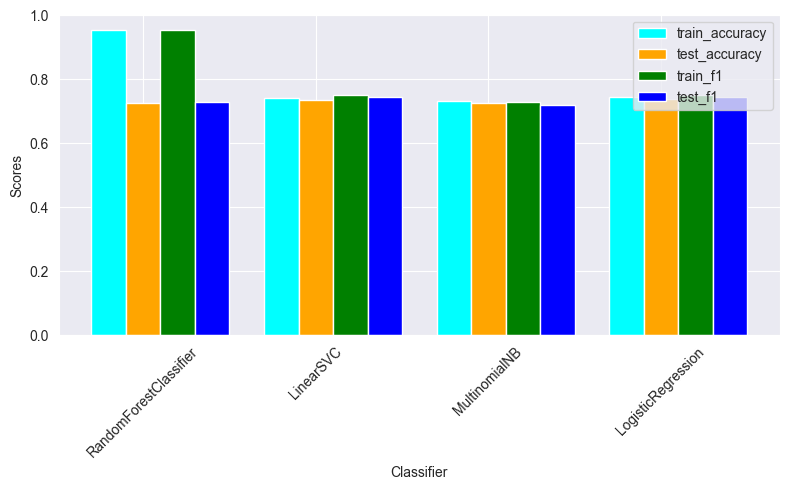

In [76]:
plt.figure(figsize=(8, 5))
width = 0.2
x = np.arange(4)
# plot data in grouped manner of bar type
plt.bar(x - 0.2, df_results['train_accuracy'], width, color='cyan')
plt.bar(x, df_results['test_accuracy'], width, color='orange')
plt.bar(x + 0.2, df_results['train_f1'], width, color='green')
plt.bar(x + 0.4, df_results['test_f1'], width, color='blue')

plt.xticks(x, list(df_results.index))
plt.xlabel("Classifier")
plt.ylabel("Scores")
plt.legend(["train_accuracy", "test_accuracy", "train_f1", "test_f1"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [77]:
X_train.shape

(128000, 1000)

In [78]:
def evaluate_model(model, X_test, y_test):
    pred = model.predict(X_test)

    accuracy = accuracy_score(y_true=y_test, y_pred=pred)
    f1 = f1_score(y_true=y_test, y_pred=pred)
    precision = precision_score(y_true=y_test, y_pred=pred)
    recall = recall_score(y_true=y_test, y_pred=pred)
    cm = confusion_matrix(y_true=y_test, y_pred=pred)

    total = np.sum(cm)

    cm = cm / total

    cm_display = ConfusionMatrixDisplay(cm).plot()
    print(f"{type(model).__name__}\n{classification_report(y_test, pred)}")

    return {'f1': f1, 'acc': accuracy, 'precision': precision, 'recall': recall}

LogisticRegression
              precision    recall  f1-score   support

           0       0.75      0.70      0.73      8000
           1       0.72      0.77      0.74      8000

    accuracy                           0.74     16000
   macro avg       0.74      0.74      0.74     16000
weighted avg       0.74      0.74      0.74     16000



{'f1': 0.7446705426356589,
 'acc': 0.7365,
 'precision': 0.7222744360902256,
 'recall': 0.7685}

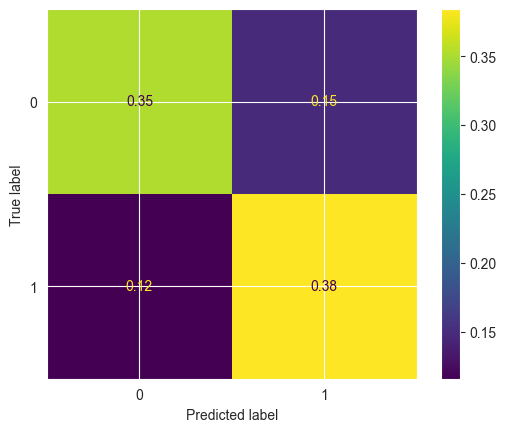

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True, stratify=y)
LogisticRegression(C=1e9, solver='lbfgs', max_iter=1000, random_state=42)
clf.fit(X_train, y_train)
evaluate_model(model=clf, X_test=X_test, y_test=y_test)

In [80]:
def plot_roc_pr(model, X_test, y_test):
    # Determine scores based on the availability of predict_proba or decision_function
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
    elif hasattr(model, 'decision_function'):
        y_score = model.decision_function(X_test)
    else:
        raise ValueError("Model does not have a predict_proba or a decision_function method.")

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

    # Calculate Precision-Recall curve
    prec, recall, _ = precision_recall_curve(y_test, y_score)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

    # Plot both ROC and Precision-Recall curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    roc_display.plot(ax=ax1)
    pr_display.plot(ax=ax2)

    ax1.set_title('ROC Curve')
    ax2.set_title('Precision-Recall Curve')
    plt.show()

LogisticRegression
              precision    recall  f1-score   support

           0       0.75      0.70      0.73      8000
           1       0.72      0.77      0.74      8000

    accuracy                           0.74     16000
   macro avg       0.74      0.74      0.74     16000
weighted avg       0.74      0.74      0.74     16000



/Users/liqing/Documents/PyCharmProjects/MachineLearningProject/.venv/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


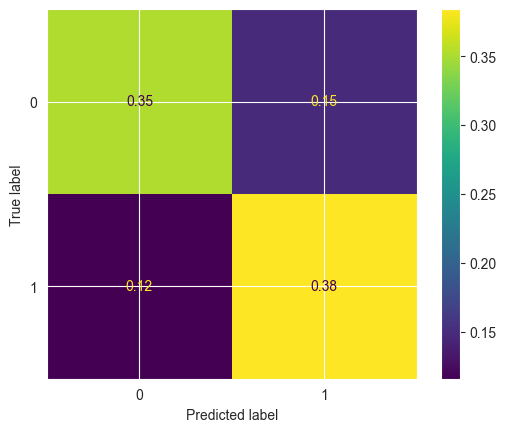

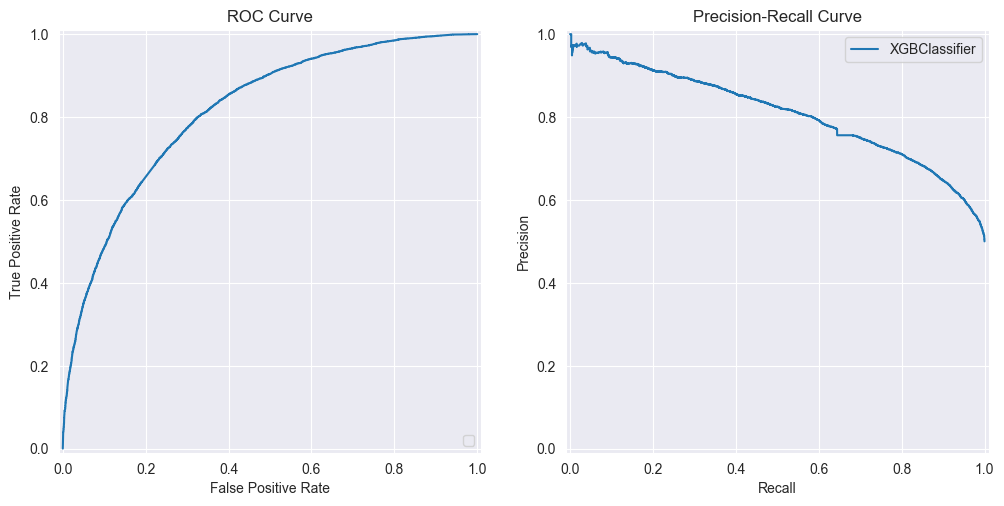

In [81]:
evaluate_model(model=clf, X_test=X_test, y_test=y_test)
yclf_score = clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_clf, tpr_clf, _ = roc_curve(y_test, yclf_score)
clf_roc_display = RocCurveDisplay(fpr=fpr_clf, tpr=tpr_clf)

# Calculate Precision-Recall curve
prec_clf, recall_clf, _ = precision_recall_curve(y_test, yclf_score)
clf_pr_display = PrecisionRecallDisplay(precision=prec_clf, recall=recall_clf)

# Plot both ROC and Precision-Recall curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
clf_roc_display.plot(ax=ax1)

clf_pr_display.plot(ax=ax2)

ax1.set_title('ROC Curve')
ax2.set_title('Precision-Recall Curve')
plt.legend(['XGBClassifier', 'GradientBoostingClassifier'])
plt.show()

### Deep Learning Models

In [82]:
X = []
X = list(data['cleaned_text'])
y = data.copy().sentiment_label.apply(lambda x: 1 if x == 4 else x)

In [83]:
X[4]

'sad closed one web services used years'

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42, shuffle=True, stratify=y)

In [85]:
X = []
X = list(data['cleaned_text'])
y = data.copy().sentiment_label.apply(lambda x: 1 if x == 4 else x)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True, stratify=y)

In [86]:

tokenizer = Tokenizer(num_words=800000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

NameError: name 'Tokenizer' is not defined

In [ ]:
X_train[4]

In [ ]:

VOCAB_SIZE = len(tokenizer.word_index) + 1
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
embeddings_dictionary = dict()
# glove_file = open('glove6B/glove.6B.100d.txt', encoding="utf-8")
glove_file = open('glove.twitter.27B.100d.txt', encoding="utf-8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()


In [ ]:
embedding_matrix = zeros((VOCAB_SIZE, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:

model = Sequential()
embedding_layer = Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(Dense(units=16, activation="relu",
                ))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

In [ ]:
utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=11, verbose=1, validation_split=0.2)

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

CNN

In [ ]:


model = Sequential()

embedding_layer = Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(Dense(units=16, activation="relu", input_shape=(
    100,)))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='ADAM', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model.summary())

In [ ]:
utils.plot_model(model, to_file='CNN_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=8, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

ROC and Precision recall curve of Logistic Regression

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Transfer Learning
Disclaimer: Run this part if you have access to a GPU. Also ensure that you restarted the colab session after reinstalling transformer. If you do not restart the colab, a cell in the code will fail with an error requesing for Accelerator.

Transfer learning is a technique that enhances the performance of learners in specific domains by leveraging knowledge from different, yet related, source domains. This approach decreases the reliance on extensive data from the target domain for developing learners.

DistilBERT is a streamlined version of the BERT model (a transformer model), designed to be smaller and more efficient. It was trained on the same data set using a method of self-supervision, with the original BERT model serving as its guide.

We will be using the distilbert-base-uncased model from hugging face

In [ ]:
model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [ ]:
X = []
X = list(data['tweet_text'])
y = data.copy().sentiment_label.apply(lambda x: 1 if x == 4 else x)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle=True,
                                                  stratify=y_train)

In [ ]:
from torch.utils.data import Dataset

'''create a class for te dataset'''


class TwitterDataset(Dataset):
    def __init__(self, encoding, labels):
        self.encodings = encoding
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)





In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

train_encoding = tokenizer(X_train, truncation=True, padding=True)
val_encoding = tokenizer(X_val, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [ ]:
train_dataset = TwitterDataset(train_encoding, list(y_train))
val_dataset = TwitterDataset(val_encoding, list(y_val))
test_dataset = TwitterDataset(test_encoding, list(y_test))

In [ ]:
from torch.utils.data import DataLoader
from transformers import AdamW

# DataLoader setup
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = DistilBertForSequenceClassification.from_pretrained(model_name)
model.to(device)
optim = AdamW(model.parameters(), lr=2e-5)
# model.train()

In [ ]:
def evaluate(model, val_loader, device):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs, labels=labels)
            val_loss += outputs.loss.item()
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            predictions.extend(preds.tolist())
            true_labels.extend(labels.tolist())

    accuracy = correct / total
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    return val_loss / len(val_loader), accuracy, precision, recall, f1


In [ ]:
# Training loop with evaluation and checkpointing
best_val_accuracy = 0.0
best_f1 = 0.0
model_save_path = 'best_model_state.bin'
num_train_epochs = 2

for epoch in range(num_train_epochs):
    model.train()
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optim.step()

    val_loss, val_accuracy, val_precision, val_recall, val_f1, = evaluate(model, val_loader, device)
    print(
        f"Epoch {epoch + 1}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val precision: {val_precision:.4f},Val recall: {val_recall:.4f}, Val F1 Score: {val_f1:.4f}")

    # Checkpointing
    if val_accuracy > best_val_accuracy and val_f1 > best_f1:
        best_val_accuracy = val_accuracy
        best_f1 = val_f1
        torch.save(model.state_dict(), model_save_path)
        print(f"New best model saved with accuracy: {val_accuracy:.4f} and f1 {val_f1:.4f}")


In [ ]:
# Load best model for prediction
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Prediction on test set
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        test_predictions.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

In [ ]:
def evaluate_bert_model(test_labels, test_predictions):
    accuracy = accuracy_score(y_true=test_labels, y_pred=test_predictions)
    f1 = f1_score(y_true=test_labels, y_pred=test_predictions)
    precision = precision_score(y_true=test_labels, y_pred=test_predictions)
    recall = recall_score(y_true=test_labels, y_pred=test_predictions)
    cm = confusion_matrix(y_true=test_labels, y_pred=test_predictions)

    cm_display = ConfusionMatrixDisplay(cm).plot()
    print(f"{type(model).__name__}\n{classification_report(test_labels, test_predictions)}")

    return {'f1': f1, 'acc': accuracy, 'precision': precision, 'recall': recall}

In [ ]:
evaluate_bert_model(test_labels, test_predictions)

In [ ]:
# Calculate performance metrics
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions)

print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")